## A Reinforcement Learning Based Approach to Demand Prediction and Location Optimization of Electric Vehicle Charging Stations in New York

## Introduction

In recent years, significant advances have been made in smart grid technology and renewable energies in order to reduce reliance on fossil fuels, which emit harmful greenhouse gases. Along with these advances in power generation and distribution, electric vehicles (EVs) have also been increasingly adopted in cities throughout the U.S. However, effective strategies are necessary to build charging infrastructure to meet this new demand for EVs, and there are still many challenges that hinder the further expansion of EV usage. 

One issue is the convenience and accessibility of charging stations - the distribution of charging stations is not always effective, and with variations in charging demand and battery sizes, there is a need for charging stations to account for a rising number of EV users while maintaining efficiency. More substantial changes to usage patterns due to population changes or even the COVID-19 pandemic can also add to the difficulty of predicting where charging stations would be most effective. Thus, charging station infrastructure can still be improved.

## Related Work

There has been substantial research in the realm of EVs and optimizing placement of charging stations, but there is not as much existing work that has addressed the specific issue of placing charging stations with a reinforcement learning approach. EV charging demand is predicted with Canonical Correlation Analysis (CCA) in Gopalakrishnan et al. (2016), utilizing auxiliary data such as Points of Interest (PoI), which are nearby buildings and institutions that could influence demand, and traffic density. 

In Almaghrebi et al. (2020), EV charging demand is predicted with supervised machine learning methods such as gradient boosting, support vector machines, and random forest as displayed below.

<p align=“center”>
    <center><img src=demand.png width=“400" height=“400” /></center>
</p>

Additionally, Wagner et al. (2013) optimizes EV charging station locations by sectioning off areas in Amsterdam that could serve as potential charging spots, forming a grid. The attractiveness of placing charge points in these areas is based on data from nearby points of interest, which is closely related to charging demand. The example below illustrates the idea of creating a grid and analyzing points of interest around potential charging locations. 

<p align=“center”>
    <center><img src=grid.png width=“400" height=“400” /></center>
</p>

A reinforcement learning based model would allow an agent to account for many different factors, such as energy consumption, charging times, budget, or coverage, while automatically navigating the environment and learning an optimal placement of charging stations in the areas with the highest demand.

## Reinforcement Learning (RL) Background

Reinforcement Learning is an area of machine learning that focuses on having an autonomous agent interact with an environment and learn to make decisions on its own. By performing actions in  the environment, the agent receives feedback from the environment--its reward--and learns to improve future actions. RL problems are typically modeled with the **Markov Decision Process (MDP)** shown below.

<p align=“center”>
    <center><img src=markov.png width=“400" height=“400” /></center>
</p>

In the standard RL setting, the agent will continually receive a state $s_t$ from the environment and will follow a policy $\pi$ in order to select an action $a_t$, with the goal of maximizing the return from each state. This return incorporates a reward $r_t$ which can be obtained from certain actions, and is represented by 

$$Q^{\pi}(s,a)=\mathbb{E}[R_t|s_t=s,a_t=a], $$ 

also known as the **action-value function**. $R_t$ denotes the reward function, and is defined by 

$$R_t=\sum_{i=0}^{\infty} \gamma^i r_{t+i},$$

where $r_t$ is the expected reward at time step $t$ and $\gamma$ is the **discount factor**, which determines how much importance the agent will place on future rewards compared to current rewards. The **optimal value function**, $Q^{*}(s,a)$, represents the maximum possible action value and is defined by 

$$Q^{*}(s,a)=\max Q^{\pi}(s,a).$$ 

One of the most common RL algorithms, Q-learning, is a **value-based method** that attempts to directly estimate the optimal value function. This is done by iteratively minimizing a sequence of loss functions and updating the value function based on the reward received from moving to the next state. Other RL methods build an explicit representation of the agent's policy, known as **policy-based methods**, and still others combine an the value-based approach with the policy-based approach into **actor-critic** type algorithms. In our proposed framework, we experiment with multiple types of these RL algorithms to optimize charging station locations

## Methods

Our approach to improve the accessibility of these charging stations is to utilize reinforcement learning to predict the expected demand at multiple locations, and to then choose optimal locations to deploy new charging stations to satisfy that demand. The goal is to maximize the coverage of new charging stations (meaning that the station is accessible to EVs within a certain distance) and minimize total costs using a predetermined budget as to ensure an efficient use of resources. Our model should also be able to adapt to new data that may show increases or decreases in overall EV usage and demand. By analyzing a variety of factors, the model will learn a useful strategy for placing charging stations.

We plan to set up an environment as described above and test multiple RL algorithms, taking into account the following factors:
- Historical usage data from existing charging stations
- Nearby points that could influence demand (e.g. schools, shops, hospitals, etc.)
- Traffic data from nearby intersections
- Average range of electric vehicles
- Costs of deploying a new charging station (e.g. licensing, number and type of charging slots)
- Charging station wait times and pricing
- EV network
- Other factors that could influence demand (hourly changes, peak demand, seasonal changes)

We plan to use two different models throughout our methods. The first model will predict energy demand by using the above factors as inputs, using supervised and unsupervised machine learning methods to find correlations in the data. This model will result in a heatmap that shows areas with high and low demand across a given region in New York. 

Then, our RL model will interact with this heatmap in addition to other factors in order to learn the best locations to place charging stations to meet the charging demand. After placing down a charging station, the first model will be called again to update the heatmap with new demand, given that there is a new charging station at the location selected by the RL agent.

## Demand Prediction Model

For our demand prediction model, we will attempt to predict the energy demand given the traffic density, EV density, number of ports, and the surrounding POIs. We test various machine learning methods from the Scikit-learn library, including Random Forest, Gradient Boosting, and Bagging.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [4]:
df = pd.read_csv('demand_data.csv')
# Drop the extra features that we don't want to use to predict
df = df.drop(['Latitude', 'Longitude', 'Nearby Stations', 'ZIP', 'Unnamed: 0'], axis=1)

We use a `train_test_split` to split up the data and train the models. The target feature will be energy demand, but in the future we will also incorporate charge duration into our model.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(['Energy Demand','Charge Duration'], axis=1)
y = df['Energy Demand']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=89)

We can print out the scores for each model. Boosting seems to have the best performance with an R^2 score of 0.85. 

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

def gboost(X_train, y_train):
    boost = GradientBoostingRegressor()
    boost.fit(X_train, y_train)
    return boost

def randforest(X_train, y_train):
    forest = RandomForestRegressor()
    forest.fit(X_train, y_train)
    return forest

def bagreg(X_train, y_train):
    bag = BaggingRegressor()
    bag.fit(X_train, y_train)
    return bag

boost = gboost(X_train, y_train)
print('Gradient Boosting: ' + str(boost.score(X_test, y_test)))

forest = randforest(X_train, y_train)
print('Random Forest: ' + str(forest.score(X_test, y_test)))

bag = bagreg(X_train, y_train)
print('Bagging: ' + str(bag.score(X_test, y_test)))

Gradient Boosting: 0.8530294266405338
Random Forest: 0.7913328870992996
Bagging: 0.7123862373255617


To get an understanding of what the model is doing, we can look at the relative importance it places on each feature. Based on this visual, it appears that the boosting model heavily favors EV density and Traffic Density as predictors of demand.

Text(0.5, 1.0, 'Feature Importance (MDI)')

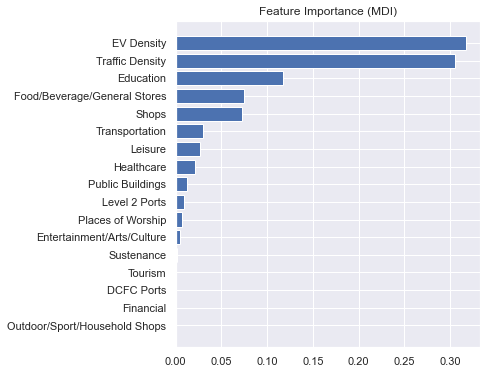

In [10]:
feature_importance = boost.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

As we continue to tune these models to increase their scores, we will hopefully test on large enough areas (rather than just Albany) so that the influence of POIs is more apparent in the models. We use this model in our reinforcement learning framework to predict demand in our environment and contribute to the reward function.

## Reinforcement Learning Environment

In order to build a model for Deep Q-Learning, we must define and create and environment. Our environment consists of a 2D grid (26 x 26) that contains energy demand values in each cell that remain static. These demand values will be one of the primary factors in calculating the agent's reward. In the upcoming weeks, we will add complexity to this model so that there is more than just demand at play (charging wait times, changing map of demand).

First, we select a section of Albany County with a reasonable amount of roads, charging stations, and POIs to train on. Using a bounding box on OpenStreetMap, we can split up the region into a 26 x 26 grid and assign traffic densities and POIs to each cell. Each grid cell is 250m on one side. Then, we use our demand prediction model to give each cell a realistic demand value assuming we construct a Level 2 EV charger in that cell. The resulting heatmap of the selected region is shown below:

<p align=“center”>
    <center><img src=dededewdw.png width=“400" height=“400” /></center>
</p>

We can build a Q-learning model based on this grid, where an agent has to navigate its way to the spots with the highest demand. Our RL agent will have five possible actions: one action for a directional movement to the north, south, east, or west, and one action that places a "charging station" at its current location. The goal of the agent is to move around to find the areas with highest demand, then place charging stations in those areas. Each episode, the agent will be placed in a random location on the grid, and rewards will be given in the following ways: if the agent places a charging station, the reward is the demand value at that location, and if the agent decides to move, the reward is proportional to the difference in demand between the agent's previous location and its next location. This will incentivize the agent to move towards "good" squares. This implementation is shown below.

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import pickle
from matplotlib import style 
import time 
import math

In [4]:
# Load in the grid (previously saved with pickle)
import pickle

with open ('C__Users_shankarpadmanabhan_Documents_CS378_pickle_test1.data', 'rb') as f:
    new_data = pickle.load(f)

Now we define variables and constants that we will use throughout the training process.

In [31]:
from copy import copy, deepcopy

HM_EPISODES = 15000 # num of total episodes (used 50000 episodes during actual training)
SHOW_EVERY = 1000 # display data every 1000 episodes
SIZE = 26
epsilon = 0.9
EPS_DECAY = 0.99999
place_prob = 0.8 # decreases the chance that the agent will place a station when picking a random action based on epsilon
DEMAND_DECREASE = 0.5 # after placing a station, attractiveness at that point goes down
TOTAL_PLACEMENTS = 10 # total num of chargers to place down
grid = deepcopy(new_data)

start_q_table = None
LEARNING_RATE = 0.1 
DISCOUNT = 0.95 # discount factor for Q-learning

Shown below is the Agent class, which is a representation of our RL agent. An important thing to note is that when the agent places a charging station, the demand at that location decreases by a factor of `DEMAND_DECREASE`. Additionally, every other cell in the grid has its demand decreased by an amount proportional to its distance from the cell with the charging station, simulating the process of placing a charger in the real world and having it decrease demand across a certain area.

In [32]:
# RL Agent class
class Agent:
    # Initialize agent to random spot on the grid
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
        self.count = TOTAL_PLACEMENTS
    
    # Get the number of stations left to place
    def get_count(self):
        return self.count

    # Can move up, down, left, right, or place station at current location    
    def action(self, choice):
        if choice == 0:
            self.move(x=1, y=0)
        elif choice == 1:
            self.move(x=-1, y=0)
        elif choice == 2:
            self.move(x=0, y=1)
        elif choice == 3:
            self.move(x=0, y=-1)
        elif choice == 4:
            self.place_station(self.x, self.y)

    # Update agent's grid position
    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # Account for hitting a wall
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE - 1:
            self.x = SIZE - 1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE - 1:
            self.y = SIZE - 1
    
    # Place station at the current location
    def place_station(self, x=False, y=False):
        value = grid[x][y] * DEMAND_DECREASE # decrease the current grid cell's demand 

        # For every cell in the grid, decrease its demand proportional to its distance from the current cell
        # This simulates the fact that placing chargers alleviates demand across an area
        for r in range(0, SIZE):
            for c in range(0, SIZE):
                dist = math.sqrt((x - r) ** 2 + (y - c) ** 2) # find Euclidean distance
                decrease = 1 / ((dist + 1) ** dist) # factor to decrease demand by
                current_val = grid[r][c]
                grid[r][c] = current_val - current_val * decrease # update the cell with decreased demand
        
        grid[x][y] = value 
        self.count -= 1 # decrement the total stations left to place

Next, we create the Q-table, which is the basis of Q-learning. Each observation and action in this environment has a Q-value that judges how "good" an action is in a certain state, and the agent's goal is to continuously update these Q-values to eventually learn the best actions for every state. At the beginning, these Q-values are randomly initialized.

In [33]:
# Creating the Q table
if start_q_table is None:
    q_table = {}
    # For every possible observation of the agent (each cell in the grid), 
    # randomly initialize Q-values
    for x1 in range(-SIZE + 1, SIZE):
        for y1 in range(-SIZE + 1, SIZE):
            q_table[((x1, y1))] = [np.random.uniform(-5, 0) for i in range(5)]
else:
    # or import an existing q table
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

Next is the primary loop that performs the learning. The overall process is that the agent takes in an observation from the environment, selects an action, obtains a reward, and then updates its Q-values based on that reward. Additionally, there is a variable `epsilon` that essentially encourages the agent to perform more random actions during the initial training stages to "explore" the environment. As training continues, the epsilon value decreases and the agent gradually begins picking only the best actions based on its Q-table.

In [34]:
episode_rewards = [] # track total rewards for each episode
all_positions = [] # track positions of the agent, for debugging purposes
ep_means = [] # track the means for every 1000 episodes

# Main reinforcement learning loop
for episode in range(HM_EPISODES):
    positions = [] # track positions of the agent
    player = Agent()

    # Show data for each 1000 episodes
    if episode % SHOW_EVERY == 0:
        print(f"on # {episode}, epsilon: {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        ep_means.append(np.mean(episode_rewards[-SHOW_EVERY:]))
        positions.append((player.x, player.y))

    episode_reward = 0

    # Number of steps to take per episode (hard coded)
    for i in range(300):
        obs = (player.x, player.y) # observation of the agent = position
        prev = grid[player.x][player.y] # set prev equal to agent's position before taking the action

        # Epsilon-greedy (chance for the agent to choose a random action (explore)) 
        if np.random.random() > epsilon:
            # choose best action based on q values
            action = np.argmax(q_table[obs])

        else:
            # choose a random action, lower the chance of choosing to place a station
            action = np.random.randint(0, 4)
            if np.random.random() > place_prob:
                 action = 4

        # take an action
        player.action(action)
        
        if action == 4:
            # if placing a station, give a reward from the original grid
            reward = grid[player.x][player.y]
            positions.append((player.x, player.y))
        else:
            # if the agent moved, give a reward based on the difference in grid values from
            # the previous cell to this cell ("gradient" to move to better locations)
            reward = (grid[player.x][player.y] - prev)

        # Updating Q-values
        new_obs = (player.x, player.y)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q 
        

        episode_reward += reward
        # Stop the loop when all stations are placed
        if player.get_count() == 0:
            break
    
    if episode % SHOW_EVERY == 0:
        all_positions.append(positions)
    
    # Reset map, boolean grid, update epsilon
    grid = deepcopy(new_data)
    episode_rewards.append(episode_reward)
    if epsilon > 0.1:
        epsilon *= EPS_DECAY

on # 0, epsilon: 0.9
1000 ep mean: nan
on # 1000, epsilon: 0.8910448058217547
1000 ep mean: 2948.267674537111
on # 2000, epsilon: 0.8821787177576952
1000 ep mean: 2980.156107652927
on # 3000, epsilon: 0.8734008491827644
1000 ep mean: 3126.5178728110855
on # 4000, epsilon: 0.8647103222940146
1000 ep mean: 3157.4293547348416
on # 5000, epsilon: 0.8561062680228179
1000 ep mean: 3150.251606424603
on # 6000, epsilon: 0.8475878259479752
1000 ep mean: 3217.5996734601754
on # 7000, epsilon: 0.8391541442096618
1000 ep mean: 3196.6161702068334
on # 8000, epsilon: 0.8308043794242427
1000 ep mean: 3214.5816985490806
on # 9000, epsilon: 0.8225376965999297
1000 ep mean: 3196.9499415373543
on # 10000, epsilon: 0.814353269053287
1000 ep mean: 3264.6568420994327
on # 11000, epsilon: 0.8062502783265522
1000 ep mean: 3202.7426276217534
on # 12000, epsilon: 0.798227914105797
1000 ep mean: 3258.256844856341
on # 13000, epsilon: 0.790285374139891
1000 ep mean: 3292.7816219826323
on # 14000, epsilon: 0.78242

While Q-learning can be effective in smaller environments, it may not be the most effective approach as we add complexity and more dimensions to our reinforcement learning. As the training results show, there is some increase in the performance of the agent, but the learning is not quite stable or consistent. Increasing the length of each episode may help the agent to explore its surroundings more, as well as adding more epochs. 

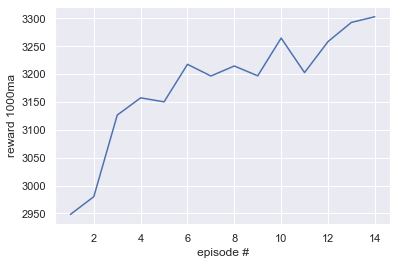

In [35]:
# Plot up the training data
plt.plot([i for i in range(HM_EPISODES // SHOW_EVERY)], ep_means)
plt.ylabel(f"reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

But with larger environments, Deep Q-Learning becomes more useful. Instead of needing a Q-table to store all possible Q-values, the Q-values for states and actions are predicted using a neural network and compared to target Q-values. There is also usually a second neural network, the target network, that is compared to the main network and is updated less frequently to increase stability. The Deep Q model also utilizes an experience replay memory, storing past experiences to then update the network after a certain amount of episodes. This improves the learning process because the weights of the neural network do not have to be updated after every experience.

## Deep Q-Learning Setup

This code is partially adapted from Renotte, N. OpenAI-Reinforcement-Learning-with-Custom-Environment (2021), GitHub repository, https://github.com/nicknochnack/OpenAI-Reinforcement-Learning-with-Custom-Environment. 

For Deep Q-Learning, we can use the same grid environment as before with the demand values in each cell. First, we will find the minimum and maximum demands, as well as the smallest and largest 10 demands which we will use later.

In [5]:
new_list = []
for arr in new_data:
    for x in arr:
        new_list.append(x)

new_list.sort()
min_single_demand = new_list[0]
minimum = 0
for x in range(0, 10):
    minimum += new_list[x]

new_list.sort(reverse=True)
max_single_demand = new_list[0]
maximum = 0
for x in range(0, 10):
    maximum += new_list[x]

Next we can begin setting up our custom environment. In this environment, the action space is an ordered pair that represents each possible grid square. An action is defined as the agent selecting a grid square to place a charger in. The states of the environment that are observed by the agent is a list of 2 values: the current accumulated demand compared to the maximum possible demand, and the current accumulated "coverage" compared to the maximum possible coverage. These comparisons are performed by taking the mean squared error of the two values.

In this problem, the coverage refers to the amount of grid cells that can be "covered" by placing a charging station. We represent this with another 2d grid where each cell has 3 possible values: a 0 means that the cell is not covered, a 1 means that the cell is covered by another charging station, and a 2 means that there is a charging station in that cell. To calculate the reward, the demand in the given cell is combined with the total increase in coverage gained from placing a station in that cell. 

Finally, the terminal state for an episode is reached when the total cost of stations exceeds the total budget; in this case, the total budget and station costs are hard coded such that a maximum of 10 stations can be placed.

In [6]:
from gym import Env
from gym import spaces
import numpy as np
import random

In [7]:
MAIN_GRID = new_data
COVER_GRID = np.zeros([26, 26])
MAX_DEMAND = maximum
MIN_DEMAND = minimum
MAX_SINGLE_DEMAND = max_single_demand
MIN_SINGLE_DEMAND = min_single_demand
MAX_COVERAGE = 260
MIN_COVERAGE = 26
STATION_COST = 1000
TOTAL_BUDGET = 10000

class ChargeEnv(Env):   
    def __init__(self):
        # Actions we can take - place a 2 or 4 port charger at a location in the grid      
        self.action_space = spaces.Tuple((spaces.Discrete(26), spaces.Discrete(26)))
        self.observation_space = spaces.Box(low=np.array([0, MIN_COVERAGE]), high=np.array([0, MAX_COVERAGE]), dtype='float64')
        self.state = np.array([MAX_DEMAND, MAX_COVERAGE]) # loss from max demand, loss from max coverage
        self.total_demand = 0
        self.total_coverage = 0 
        self.budget = TOTAL_BUDGET # total budget

    def get_demand(self, action):
        return MAIN_GRID[action[0]][action[1]]
    
    def inbounds(self, x, y):
        return x >= 0 and x < len(COVER_GRID) and y >= 0 and y < len(COVER_GRID[0])

    def update_coverages(self, action):
        total = 0 if COVER_GRID[action[0]][action[1]] == 2 else 2
        COVER_GRID[action[0]][action[1]] = 2
        cover_size = 3
        for i in range(action[0] - cover_size, action[0] + cover_size + 1):
            for j in range(action[1] - cover_size, action[1] + cover_size + 1):
                if self.inbounds(i, j):
                    if COVER_GRID[action[0]][action[1]] == 0:
                        COVER_GRID[action[0]][action[1]] = 1
                        total += 1
        return total
    
    def get_reward(self, action):
        reward = -1
        demand = 0
        if COVER_GRID[action[0]][action[1]] != 2:
            demand = self.get_demand(action)
            demand = float((demand - MIN_SINGLE_DEMAND)) / float((MAX_SINGLE_DEMAND - MIN_SINGLE_DEMAND))
            self.total_demand += self.get_demand(action)
        reward = demand + float(self.update_coverages(action)) / float(MIN_COVERAGE)
        return reward

    def get_coverage(self, action):
        total = 0
        for row in COVER_GRID:
            for x in row:
                total += x
        return total
        
    def step(self, action):
        # Calculate reward
        reward = self.get_reward(action)
        # Update variables
        # FIX: don't update demand when placing in same spot
        self.total_coverage = self.get_coverage(action)
        self.state[0] = 0.5 * ((MAX_DEMAND - self.total_demand) ** 2)
        self.state[1] = 0.5 * ((MAX_COVERAGE - self.total_coverage) ** 2)
        self.budget -= STATION_COST

        
        # Check if shower is done
        if self.budget <= 0: 
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}
        
        # Return step information
        return np.array(self.state).reshape(1, -1), reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset shower temperature
        self.state = np.array([0, 0])
        self.COVER_GRID = np.zeros([26, 26])
        self.budget = 10000
        return self.state

We can verify that our environment is working by creating an instance of it and seeing the results of randomly selected actions within the action space.

In [8]:
env = ChargeEnv()

C:\Users\allen\anaconda3\envs\tf\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
        
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:3.4928971241109767
Episode:2 Score:4.658799051653622
Episode:3 Score:4.6085238319377275
Episode:4 Score:2.4841762060019525
Episode:5 Score:4.417452799463334
Episode:6 Score:3.771260516581514
Episode:7 Score:3.9643359621218455
Episode:8 Score:4.486344573631132
Episode:9 Score:3.7724118856219793
Episode:10 Score:2.6782335586673485


As shown by these results, the reward varies with different actions selected, and they seem to be reasonable values to build off of and test with.

## Deep Q Learning Agent

We use keras to construct the neural network for our Deep Q-Learning Agent -- the Deep Q-Network. We decided to start with one input layer, a hidden layer, and an output layer using a sequential model. The input and hidden layers use the ReLU activation function. We then build the model with our actions and states.

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
states = env.observation_space.shape
actions = 676
states

(2,)

In [12]:
def build_model(states, actions):
    model = Sequential()   
    model.add(Dense(24, activation='relu', input_shape=(2,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model
# del model

In [13]:
model = build_model(states, actions)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 676)               16900     
Total params: 17,572
Trainable params: 17,572
Non-trainable params: 0
_________________________________________________________________


As shown by the model summary, we now have the architecture for our Deep Q-Learning Agent. Moving forward, we will continue to obtain results from training the Q-learning and the Deep Q-Learning models, as well as add more features and complexity into our models and potentially combine the two models to tackle larger areas of New York. 

## References

Almaghrebi, A., Aljuheshi, F., Rafaie, M. et al. 2020. Data-Driven Charging Demand Prediction at Public Charging Stations Using Supervised Machine Learning Regression Methods. Energies 13(16): 4231.

Flammini, M. G., Prettico, G., Andreea, J. et al. 2019. Statistical characterisation of the real transaction data gathered from electric vehicle charging stations. Electric Power Systems Research 166(1): 136-150. https://doi.org/10.1016/j.epsr.2018.09.022

Gopalakrishnan, R., Biswas, A., Lightwala, A. et al. 2016. Demand Prediction and Placement Optimization for Electric Vehicle Charging Stations. In Proceedings of the Twenty-Fifth International Joint Conference on Artificial Intelligence, New York, NY, July 9-15, 2016.

He, J., Yang, H., Tang, T., et al. 2017. An Optimal Charging Station Location Model With The Consideration of Electric Vehicle’s Driving Range. Transportation Research Part C: Emerging Technologies 86(1): 641-654. https://doi.org/10.1016/j.trc.2017.11.026.

Lam, A., Leung, Y., Chu, X., 2013. Electric vehicle charging station placement. Smart Grid communication, Oct 2013.

Lee, K., A. Ahmed, M., Kang et al. 2020. Deep Reinforcement Learning Based Optimal Route and Charging Station Selection. Energies, Numerical Modeling and Machine Learning Techniques, 27 Nov 2020. https://doi.org/10.3390/en13236255.

Lucas, A., Prettico, G., Flammini, M. G. et al. 2018. Indicator-Based Methodology for Assessing EV Charging Infrastructure Using Exploratory Data Analysis. Energies 11(7): 1869. https://doi.org/10.3390/en11071869. 

Palomino, A., Parvania, M., Zane, R., 2020. Impact of COVID-19 on Mobility and Electric Vehicle Charging Load.

Prabadevi, B., Quoc-Viet, P., Madhusanka,L. et al. 2021. “Deep Learning for Intelligent Demand Response and Smart Grids: A Comprehensive Survey.” 

Shahraki, N., Cai, H., Turkay, M., et al. 2015. Optimal Locations of Electric Public Charging Stations Using Real World Vehicle Travel Patterns. Transportation Research Part D: Transport and Environment 44(1): 165-176. https://doi.org/10.1016/j.trd.2015.09.011.

Wagner, S., Götzinger, M., Neumann, D. 2013. Optimal Location of Charging Stations in Smart Cities: A Point of Interest Based Approach. Thirty Fourth International Conference on Information Systems, Milan, Italy, 15-18 December, 2013. 

Zhu, Juncheng, Yang, Z., Mourshed, M., Guo, Y., Zhou, Y., Chang, Y., Wei, Y., Feng, S., 2019. Electric Vehicle Charging Load Forecasting: A Comparative Study of Deep Learning Approaches. Energies, July 2019.http://dx.doi.org/10.3390/en12142692 
